In [2188]:
#import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import math
from sklearn import linear_model
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [2189]:
def get_median_filtered(signal, threshold=4):
    signal = signal.copy()
    signal=signal.reset_index()
    difference = np.abs(signal['height'] - np.median(signal['height']))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s < threshold
    return signal.iloc[np.where(mask)[0]]

In [2190]:
file_path = '/Users/zhaoxiangyu/Downloads/'
slope_link=pd.read_pickle(os.path.join(file_path, 'slope_from_link.pkl'))
slope_probe=pd.read_pickle(os.path.join(file_path, 'probe_link_output.pkl'))
link_ID=slope_probe.groupby('linkPVID')['linkPVID'].count().index

In [2191]:
ct=np.array(slope_probe.groupby('linkPVID')['linkPVID'].count().values)
linkID=np.array(slope_probe.groupby('linkPVID')['linkPVID'].count().index)
count_id=pd.DataFrame(ct,linkID).reset_index()
count_id.columns=['index','count']

In [2324]:
count_id.sort_values(by=['count'],ascending=False).head(7)

,index,count
596,554713753.0,268
107,51921719.0,194
597,554713754.0,185
598,554713756.0,147
104,51921706.0,141
1309,772727760.0,134
1460,792551287.0,126


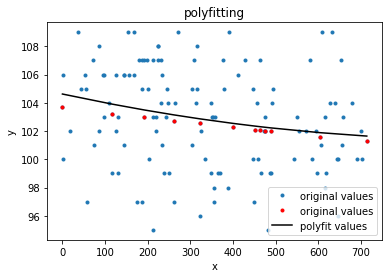

<Figure size 432x288 with 0 Axes>

In [2325]:
combine_all_output=pd.DataFrame()
#Please Input a maigc number is in Range of (0,1555)
for i in count_id.sort_values(by=['count'],ascending=False).index[5:6]:
    magic_number=i
    a=slope_probe.iloc[np.where(slope_probe['linkPVID']==link_ID[magic_number])].copy()
    b=slope_link.iloc[np.where(slope_link['linkPVID']==link_ID[magic_number])].copy()
    total=pd.concat([a, b])
    total['distFromRef']=total['distFromRef'].astype(float)
    total['distFromRef']=total['distFromRef']+100000
    total['height']=total['height'].astype(float)
    total['slope']=total['slope'].astype(float)
    total['distFromRef_root']=total['distFromRef']**(1/2)
    total=total.sort_values(by=['distFromRef'])
    total=total.reset_index()
    total=total.drop(columns="index")
    index_link=np.where(total['slope'].notna())[0]
    total_1=get_median_filtered(total,3)
    reg.fit(total_1[['distFromRef_root','distFromRef']],total_1['height'])
    total['height_prediction']=reg.predict(total[['distFromRef_root','distFromRef']])
    final=total.iloc[index_link]
    x=total_1['distFromRef']-100000
    y=total_1['height']
    xvals=final['distFromRef']-100000
    yvals=final['height_prediction']
    plot1 = plt.plot(x, y, '.',label='original values')
    plot1 = plt.plot(xvals, final['height'], '.', color = 'red' ,label='original values')
    plot3 = plt.plot(xvals, yvals, 'black',label='polyfit values')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc=4) #指定legend的位置右下角
    plt.title('polyfitting')
    plt.show()
    plt.savefig('test.png')
    output=final.copy()
    output['distFromRef']=output['distFromRef']-100000
    output['distFromRef_root']=output['distFromRef']**0.5
    output['slope_prediction']=der_formula(reg.coef_,final['distFromRef'])
    combine_all_output=pd.concat([combine_all_output,output])

In [2326]:
def formula(coef,intercept,x):
    return coef[1]*x+coef[0]*(x**(1/2))+intercept
def der_formula(coef,x):

    temp=coef[1]+coef[0]*((x+0.00001)**(-1/2))*(1/2)
    return np.arctan(temp)*360/2/math.pi

In [2327]:
rmse=((combine_all_output['slope_prediction']-combine_all_output.iloc[1:]['slope'])**2).sum()**(1/2)

In [2328]:
rmse

0.2059911881652352

In [2329]:
combine_all_output

,distFromRef,height,linkPVID,slope,distFromRef_root,height_prediction,slope_prediction
0,0.00,103.73,772727760.0,-0.265,0.000000,104.624329,-0.373120
17,116.69,103.24,772727760.0,-0.210,10.802315,103.909173,-0.329179
38,192.30,102.97,772727760.0,-0.194,13.867228,103.493534,-0.300747
61,260.85,102.74,772727760.0,-0.188,16.150851,103.149117,-0.274998
72,323.08,102.54,772727760.0,-0.188,17.974426,102.863118,-0.251645
89,400.60,102.28,772727760.0,-0.191,20.014994,102.542308,-0.222586
96,451.45,102.11,772727760.0,-0.192,21.247353,102.353214,-0.203542
100,464.15,102.07,772727760.0,-0.192,21.544141,102.308624,-0.198788
105,475.55,102.03,772727760.0,-0.192,21.807109,102.269496,-0.194521
109,487.93,101.99,772727760.0,-0.191,22.089138,102.227966,-0.189888
